In [1]:
# Cell 1: Import and setup
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create output directory
os.makedirs('results/visualizations', exist_ok=True)

print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Cell 2: Load the graph
GRAPH_PATH = '../data/processed/model_ready/earthquake_graph.pt'

print("Loading graph...")
data = torch.load(GRAPH_PATH, weights_only=False)

print(f"✓ Graph loaded!")
print(f"  Nodes: {data.num_nodes}")
print(f"  Edges: {data.num_edges}")
print(f"  Features: {data.num_node_features}")

# Extract data for visualization
coords = data.x[:, :2].numpy()  # lat, lon
magnitudes = data.y.numpy()
edge_index = data.edge_index.numpy()

Loading graph...
✓ Graph loaded!
  Nodes: 5727
  Edges: 75554
  Features: 28


FileNotFoundError: [Errno 2] No such file or directory: '../results/figures/earthquake_graph_overview.png'

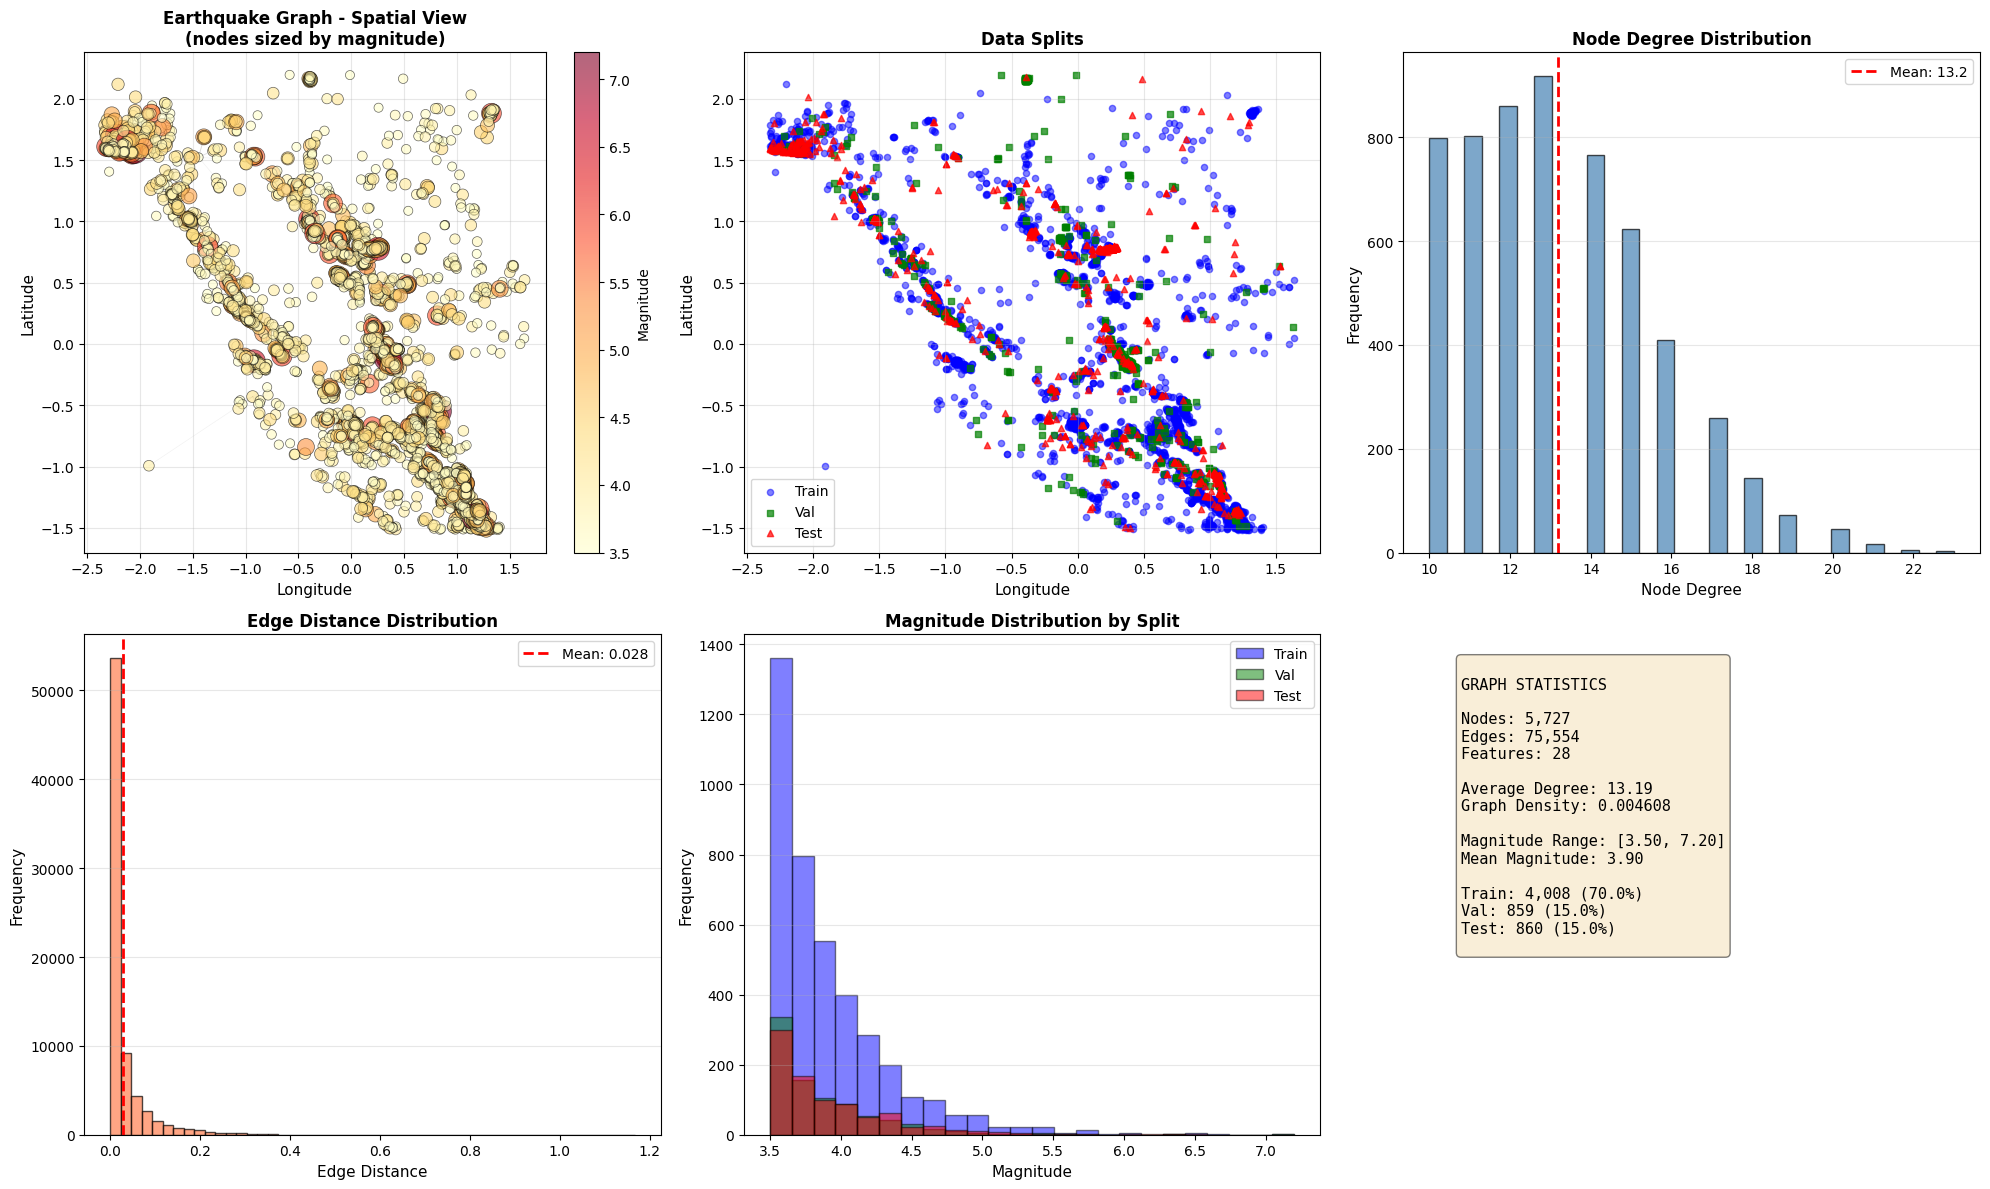

In [3]:
# Cell 3: Main visualization - 6 panel overview
fig = plt.figure(figsize=(20, 12))

# 1. Spatial Graph with Edges
ax1 = plt.subplot(2, 3, 1)

# Plot edges (sample for clarity)
for i in range(min(edge_index.shape[1], 500)):
    src, dst = edge_index[0, i], edge_index[1, i]
    ax1.plot([coords[src, 1], coords[dst, 1]], 
            [coords[src, 0], coords[dst, 0]], 
            'gray', alpha=0.1, linewidth=0.5, zorder=1)

# Plot nodes colored by magnitude
scatter = ax1.scatter(coords[:, 1], coords[:, 0], 
                     c=magnitudes, cmap='YlOrRd', 
                     s=magnitudes**3, alpha=0.6, 
                     edgecolors='black', linewidth=0.5, zorder=2)

ax1.set_xlabel('Longitude', fontsize=11)
ax1.set_ylabel('Latitude', fontsize=11)
ax1.set_title('Earthquake Graph - Spatial View\n(nodes sized by magnitude)', 
             fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Magnitude')
ax1.grid(True, alpha=0.3)

# 2. Train/Val/Test Split
ax2 = plt.subplot(2, 3, 2)

train_coords = coords[data.train_mask.numpy()]
val_coords = coords[data.val_mask.numpy()]
test_coords = coords[data.test_mask.numpy()]

ax2.scatter(train_coords[:, 1], train_coords[:, 0], 
           c='blue', s=20, alpha=0.5, label='Train', marker='o')
ax2.scatter(val_coords[:, 1], val_coords[:, 0], 
           c='green', s=20, alpha=0.7, label='Val', marker='s')
ax2.scatter(test_coords[:, 1], test_coords[:, 0], 
           c='red', s=20, alpha=0.7, label='Test', marker='^')

ax2.set_xlabel('Longitude', fontsize=11)
ax2.set_ylabel('Latitude', fontsize=11)
ax2.set_title('Data Splits', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Node Degree Distribution
ax3 = plt.subplot(2, 3, 3)

degrees = np.bincount(edge_index[0])

ax3.hist(degrees, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(degrees.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {degrees.mean():.1f}')
ax3.set_xlabel('Node Degree', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Node Degree Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Edge Distance Distribution
ax4 = plt.subplot(2, 3, 4)

if hasattr(data, 'edge_attr') and data.edge_attr is not None:
    edge_distances = data.edge_attr.numpy().flatten()
    ax4.hist(edge_distances, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax4.axvline(edge_distances.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {edge_distances.mean():.3f}')
    ax4.set_xlabel('Edge Distance', fontsize=11)
    ax4.set_ylabel('Frequency', fontsize=11)
    ax4.set_title('Edge Distance Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

# 5. Magnitude Distribution by Split
ax5 = plt.subplot(2, 3, 5)

train_mags = magnitudes[data.train_mask.numpy()]
val_mags = magnitudes[data.val_mask.numpy()]
test_mags = magnitudes[data.test_mask.numpy()]

bins = np.linspace(magnitudes.min(), magnitudes.max(), 25)
ax5.hist(train_mags, bins=bins, alpha=0.5, label='Train', color='blue', edgecolor='black')
ax5.hist(val_mags, bins=bins, alpha=0.5, label='Val', color='green', edgecolor='black')
ax5.hist(test_mags, bins=bins, alpha=0.5, label='Test', color='red', edgecolor='black')

ax5.set_xlabel('Magnitude', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Magnitude Distribution by Split', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Graph Statistics
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

avg_degree = degrees.mean()
density = (2 * data.num_edges) / (data.num_nodes * (data.num_nodes - 1))

stats_text = f"""
GRAPH STATISTICS

Nodes: {data.num_nodes:,}
Edges: {data.num_edges:,}
Features: {data.num_node_features}

Average Degree: {avg_degree:.2f}
Graph Density: {density:.6f}

Magnitude Range: [{magnitudes.min():.2f}, {magnitudes.max():.2f}]
Mean Magnitude: {magnitudes.mean():.2f}

Train: {data.train_mask.sum().item():,} ({data.train_mask.sum().item()/data.num_nodes*100:.1f}%)
Val: {data.val_mask.sum().item():,} ({data.val_mask.sum().item()/data.num_nodes*100:.1f}%)
Test: {data.test_mask.sum().item():,} ({data.test_mask.sum().item()/data.num_nodes*100:.1f}%)
"""

ax6.text(0.1, 0.95, stats_text, transform=ax6.transAxes,
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../results/figures/earthquake_graph_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/visualizations/earthquake_graph_overview.png")

Loaded 1679 earthquakes with original coordinates
  Lat: 32.05 to 41.99
  Lon: -125.00 to -114.03
✓ Plotted 1000 earthquakes at correct California locations
Loading fault data...
  Found 77827 fault segments in California
✓ Fault lines loaded


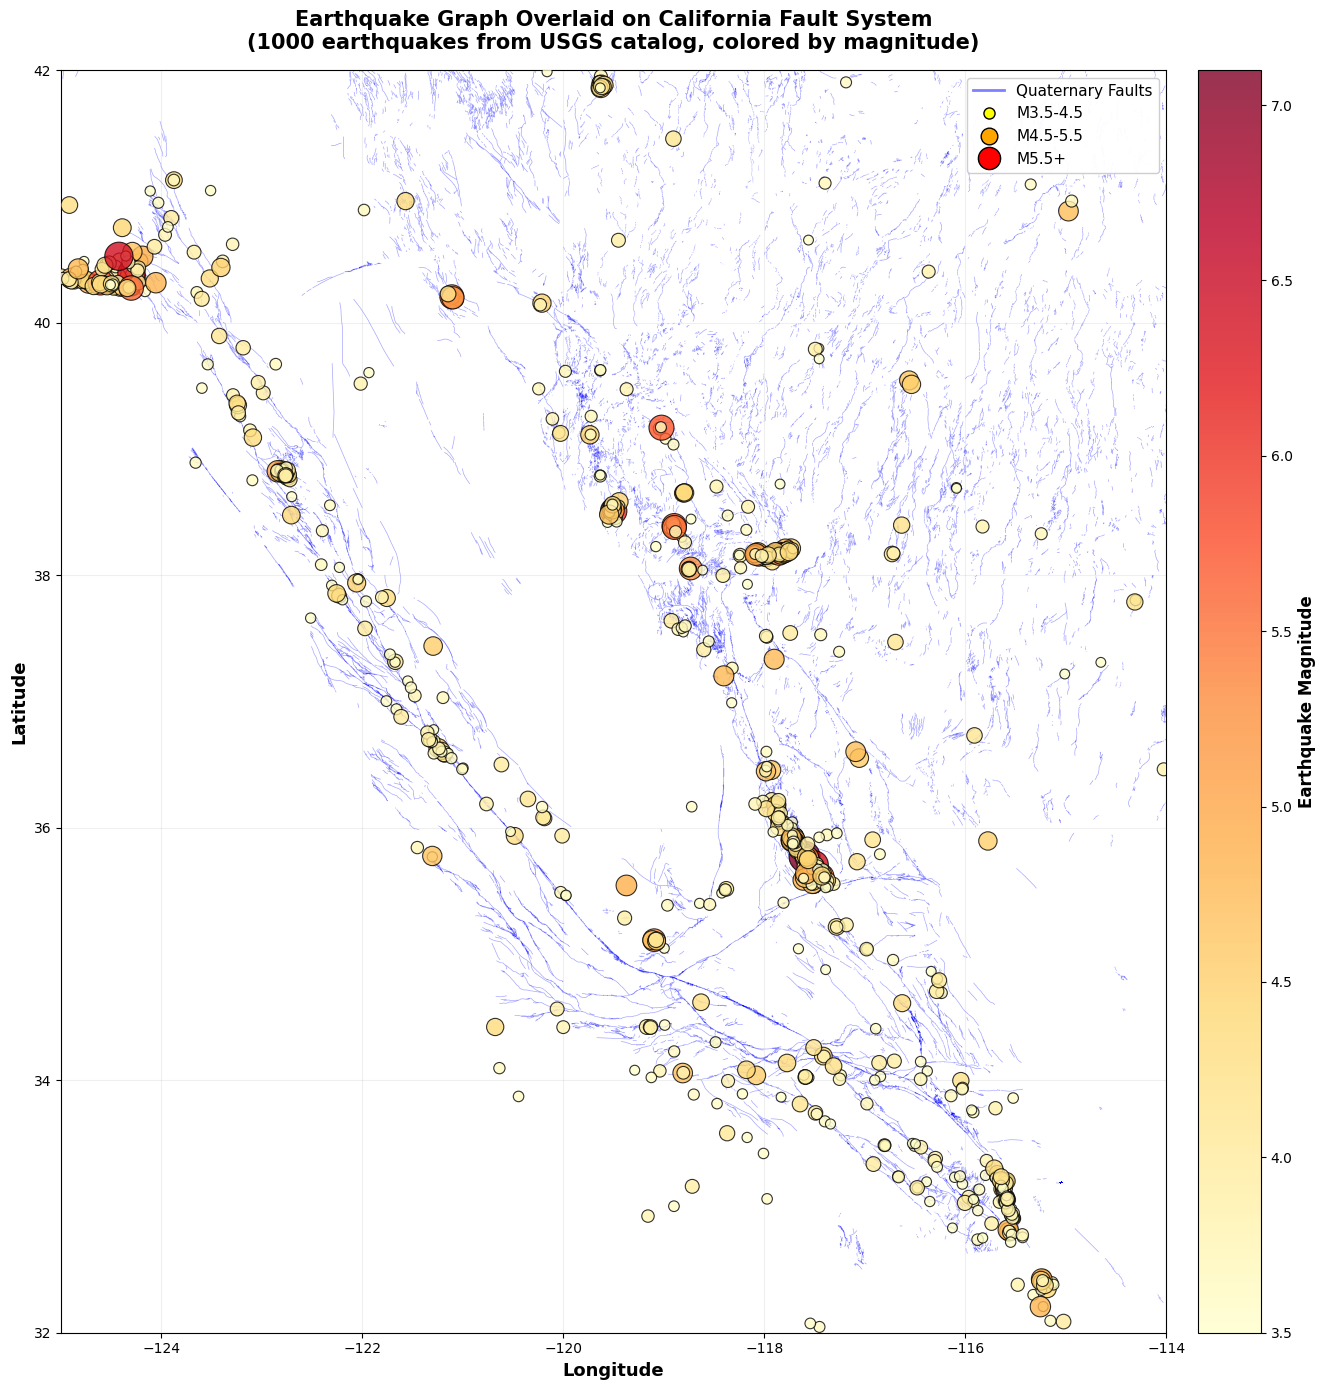

✓ Saved: results/visualizations/fault_overlay.png


In [ ]:
# Cell 2 (FINAL FIX): Using Original Unnormalized Coordinates
import pandas as pd

# Load original coordinates
df_original = pd.read_csv('../data/processed/earthquakes_cleaned.csv')

print(f"Loaded {len(df_original)} earthquakes with original coordinates")
print(f"  Lat: {df_original['latitude'].min():.2f} to {df_original['latitude'].max():.2f}")
print(f"  Lon: {df_original['longitude'].min():.2f} to {df_original['longitude'].max():.2f}")

# Use original coordinates for visualization
coords_original = df_original[['latitude', 'longitude']].values
magnitudes_original = df_original['magnitude'].values

# Sample for visualization
sample_size = min(1000, len(coords_original))
np.random.seed(42)
sample_indices = np.random.choice(len(coords_original), sample_size, replace=False)

sample_lats = coords_original[sample_indices, 0]
sample_lons = coords_original[sample_indices, 1]
sample_mags = magnitudes_original[sample_indices]

# Create figure
fig, ax = plt.subplots(figsize=(16, 14))

# Create size scaling
sizes = 50 + (sample_mags - sample_mags.min()) / (sample_mags.max() - sample_mags.min()) * 450

# Plot earthquake nodes FIRST
scatter = ax.scatter(sample_lons, sample_lats, 
                    c=sample_mags, 
                    cmap='YlOrRd', 
                    s=sizes,
                    alpha=0.8,
                    edgecolors='black',
                    linewidth=0.8, 
                    zorder=10)

print(f"✓ Plotted {len(sample_indices)} earthquakes at correct California locations")

# Load and plot fault lines
fault_file = '../data/raw/external/faults/SHP/Qfaults_US_Database.shp'

try:
    import geopandas as gpd
    print(f"Loading fault data...")
    
    gdf = gpd.read_file(fault_file)
    
    # Filter for California faults
    gdf_ca = gdf.cx[-125.0:-114.0, 32.0:42.0]
    
    print(f"  Found {len(gdf_ca)} fault segments in California")
    
    # Plot faults
    gdf_ca.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.35, zorder=1, label='Quaternary Faults')
    
    print("✓ Fault lines loaded")
    
except Exception as e:
    print(f"⚠️ Could not load faults: {e}")

ax.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax.set_title('Earthquake Graph Overlaid on California Fault System\n(1000 earthquakes from USGS catalog, colored by magnitude)', 
            fontsize=15, fontweight='bold', pad=15)

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', linewidth=2, alpha=0.5, label='Quaternary Faults'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', 
           markersize=8, label=f'M3.5-4.5', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
           markersize=12, label=f'M4.5-5.5', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=16, label=f'M5.5+', markeredgecolor='black'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.95)

ax.grid(True, alpha=0.2, zorder=0)
ax.set_facecolor('white')

cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Earthquake Magnitude', fontsize=12, fontweight='bold')

# Set proper California bounds
ax.set_xlim(-125, -114)
ax.set_ylim(32, 42)

plt.tight_layout()
plt.savefig('../results/figures/fault_overlay.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: results/visualizations/fault_overlay.png")

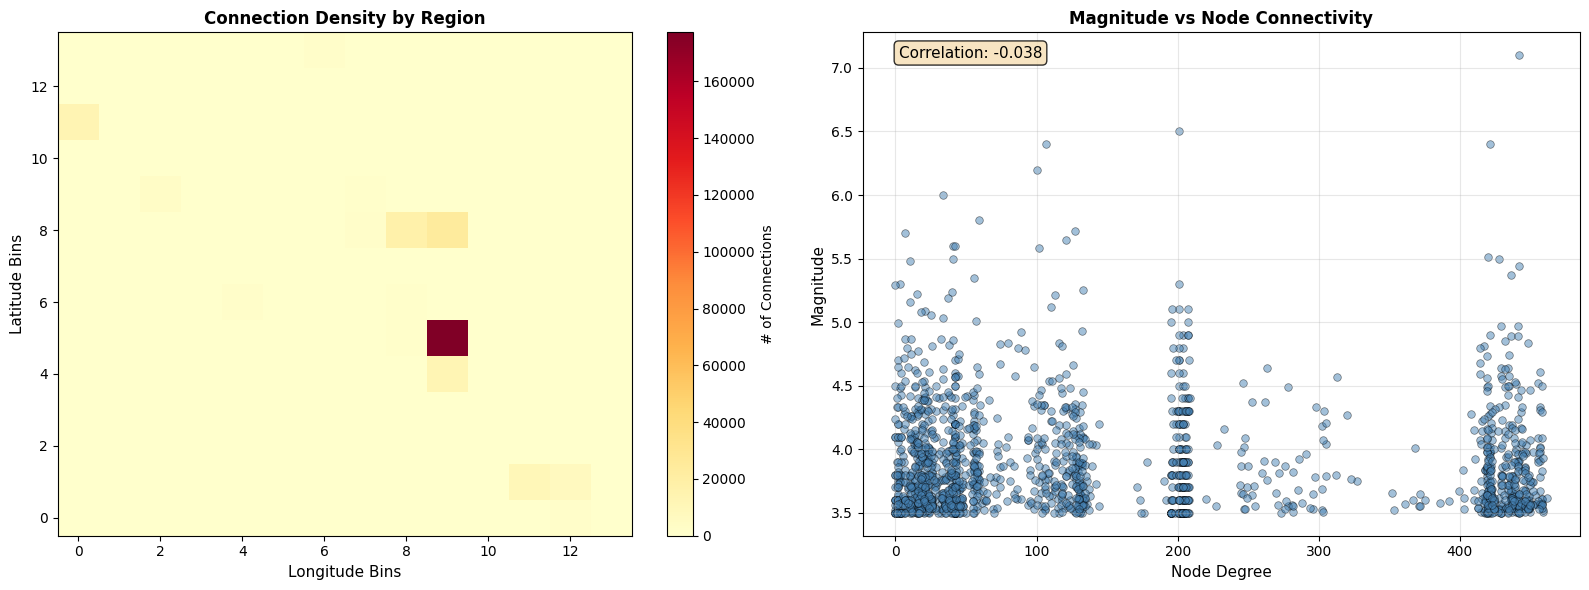

✓ Saved: results/visualizations/connectivity_analysis.png


In [ ]:
# Cell 5: Connectivity analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Connection density heatmap
ax1 = axes[0]

lat_bins = np.linspace(coords[:, 0].min(), coords[:, 0].max(), 15)
lon_bins = np.linspace(coords[:, 1].min(), coords[:, 1].max(), 15)

grid_connections = np.zeros((len(lat_bins)-1, len(lon_bins)-1))

for i in range(data.num_nodes):
    lat_idx = np.digitize(coords[i, 0], lat_bins) - 1
    lon_idx = np.digitize(coords[i, 1], lon_bins) - 1
    
    if 0 <= lat_idx < len(lat_bins)-1 and 0 <= lon_idx < len(lon_bins)-1:
        num_edges = np.sum(edge_index[0] == i)
        grid_connections[lat_idx, lon_idx] += num_edges

im1 = ax1.imshow(grid_connections, cmap='YlOrRd', aspect='auto', origin='lower')
ax1.set_xlabel('Longitude Bins', fontsize=11)
ax1.set_ylabel('Latitude Bins', fontsize=11)
ax1.set_title('Connection Density by Region', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='# of Connections')

# 2. Magnitude vs Degree
ax2 = axes[1]

degrees_full = np.bincount(edge_index[0], minlength=data.num_nodes)

ax2.scatter(degrees_full, magnitudes, alpha=0.5, s=30, color='steelblue', 
           edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Node Degree', fontsize=11)
ax2.set_ylabel('Magnitude', fontsize=11)
ax2.set_title('Magnitude vs Node Connectivity', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

corr = np.corrcoef(degrees_full, magnitudes)[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
        transform=ax2.transAxes, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('../results/figures/connectivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/visualizations/connectivity_analysis.png")

Creating spatiotemporal 3D visualization...
Time range: 2015-01-04 03:18:09.480000 to 2024-12-29 00:21:10.260000
Duration: 3646 days
Created 581 temporal edges


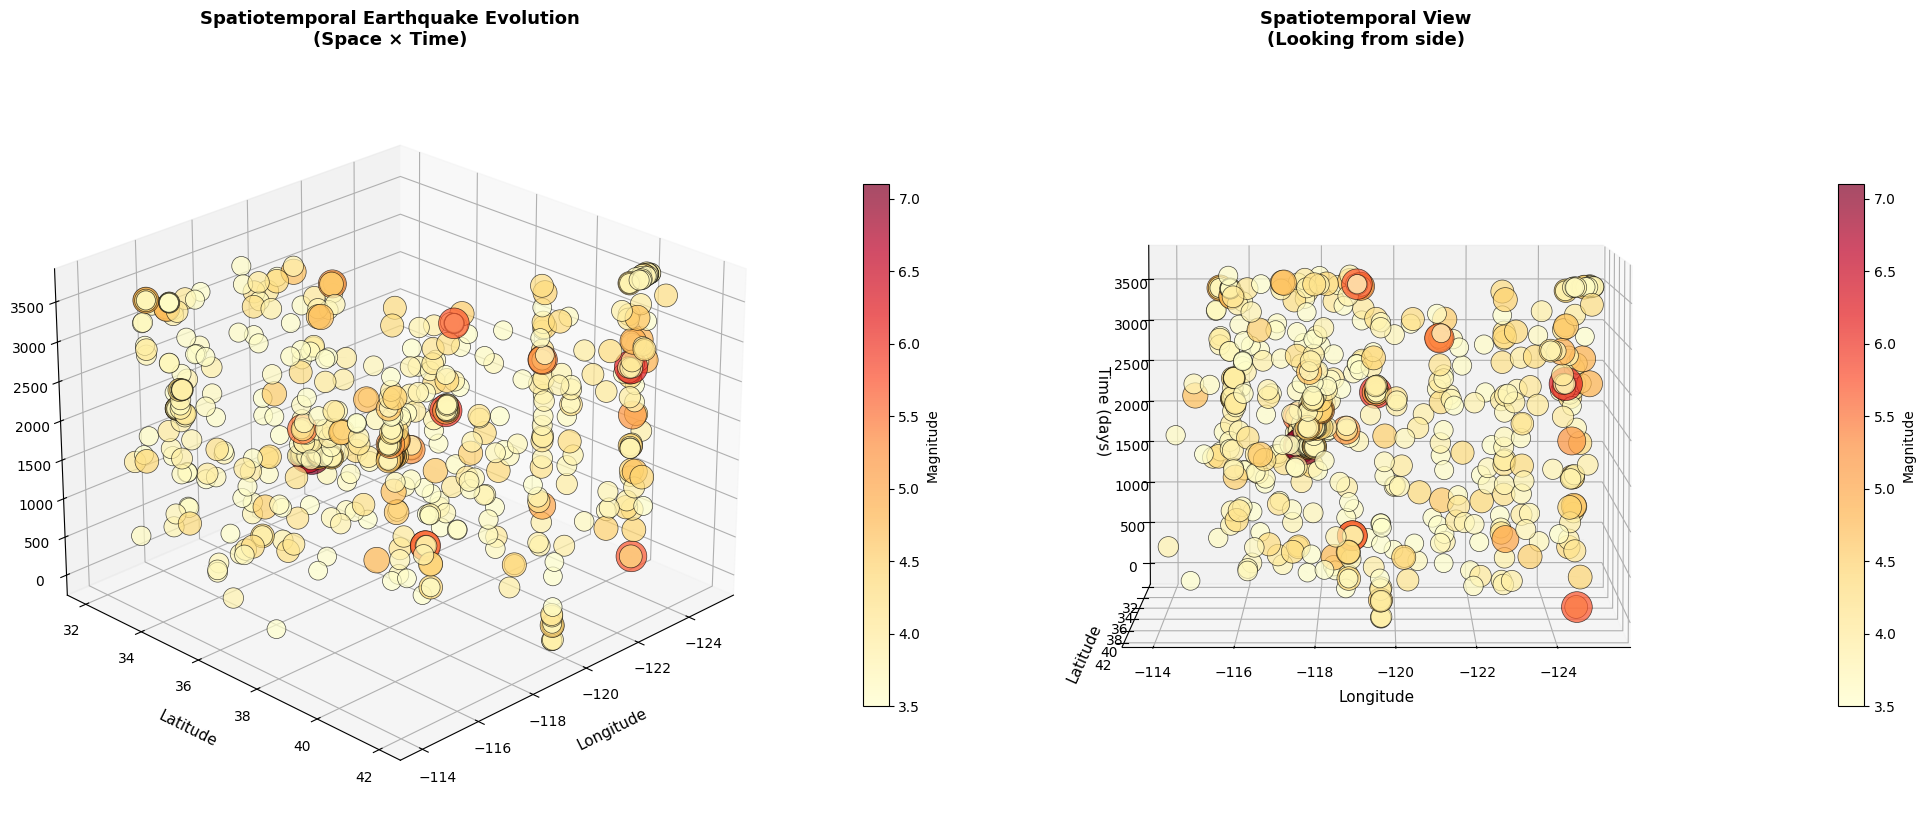

✓ Saved: results/visualizations/spatiotemporal_3d.png


In [ ]:
# Cell: Spatiotemporal 3D Visualization (Space + Time)
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from datetime import datetime

print("Creating spatiotemporal 3D visualization...")

# Load original data with time information
df_original = pd.read_csv('../data/processed/earthquakes_cleaned.csv')
df_original['time'] = pd.to_datetime(df_original['time'])

# Extract data
coords_original = df_original[['latitude', 'longitude']].values
magnitudes_original = df_original['magnitude'].values
times = df_original['time'].values

# Convert time to numeric (days since first earthquake)
time_numeric = (pd.to_datetime(times) - pd.to_datetime(times).min()).days.values

print(f"Time range: {df_original['time'].min()} to {df_original['time'].max()}")
print(f"Duration: {time_numeric.max()} days")

# Sample for visualization
sample_size_3d = min(800, len(coords_original))
np.random.seed(42)
sample_3d = np.random.choice(len(coords_original), sample_size_3d, replace=False)

# Sort by time for better edge visualization
sample_3d = sample_3d[np.argsort(time_numeric[sample_3d])]

# Create figure with two views
fig = plt.figure(figsize=(20, 9))

# View 1: Spatiotemporal view
ax1 = fig.add_subplot(121, projection='3d')

# Create temporal edges (connect earthquakes close in time and space)
temporal_edges = []
for i in sample_3d:
    # Find nearby events in time (within 30 days)
    time_diff = np.abs(time_numeric - time_numeric[i])
    spatial_dist = np.sqrt((coords_original[:, 0] - coords_original[i, 0])**2 + 
                          (coords_original[:, 1] - coords_original[i, 1])**2)
    
    # Connect to nearest spatial neighbor within 30 days
    candidates = np.where((time_diff < 30) & (time_diff > 0) & (spatial_dist < 0.5))[0]
    if len(candidates) > 0:
        closest = candidates[np.argmin(spatial_dist[candidates])]
        temporal_edges.append((i, closest))

print(f"Created {len(temporal_edges)} temporal edges")

# Plot temporal edges
for src, dst in temporal_edges[:500]:  # Limit for clarity
    ax1.plot3D([coords_original[src, 1], coords_original[dst, 1]], 
               [coords_original[src, 0], coords_original[dst, 0]],
               [time_numeric[src], time_numeric[dst]],
               'gray', alpha=0.1, linewidth=0.3)

# Plot earthquake nodes colored by magnitude
scatter1 = ax1.scatter(coords_original[sample_3d, 1], 
                      coords_original[sample_3d, 0], 
                      time_numeric[sample_3d],
                      c=magnitudes_original[sample_3d], 
                      cmap='YlOrRd', 
                      s=magnitudes_original[sample_3d]**2 * 15, 
                      alpha=0.7,
                      edgecolors='black', 
                      linewidth=0.5)

ax1.set_xlabel('Longitude', fontsize=11, labelpad=10)
ax1.set_ylabel('Latitude', fontsize=11, labelpad=10)
ax1.set_zlabel('Time (days since start)', fontsize=11, labelpad=10)
ax1.set_title('Spatiotemporal Earthquake Evolution\n(Space × Time)', 
             fontsize=13, fontweight='bold', pad=20)

cbar1 = plt.colorbar(scatter1, ax=ax1, pad=0.1, shrink=0.6)
cbar1.set_label('Magnitude', fontsize=10)

ax1.view_init(elev=25, azim=45)

# View 2: Top-down time view
ax2 = fig.add_subplot(122, projection='3d')

# Same data, different angle
scatter2 = ax2.scatter(coords_original[sample_3d, 1], 
                      coords_original[sample_3d, 0], 
                      time_numeric[sample_3d],
                      c=magnitudes_original[sample_3d], 
                      cmap='YlOrRd', 
                      s=magnitudes_original[sample_3d]**2 * 15, 
                      alpha=0.7,
                      edgecolors='black', 
                      linewidth=0.5)

# Plot some temporal edges
for src, dst in temporal_edges[:500]:
    ax2.plot3D([coords_original[src, 1], coords_original[dst, 1]], 
               [coords_original[src, 0], coords_original[dst, 0]],
               [time_numeric[src], time_numeric[dst]],
               'gray', alpha=0.1, linewidth=0.3)

ax2.set_xlabel('Longitude', fontsize=11, labelpad=10)
ax2.set_ylabel('Latitude', fontsize=11, labelpad=10)
ax2.set_zlabel('Time (days)', fontsize=11, labelpad=10)
ax2.set_title('Spatiotemporal View\n(Looking from side)', 
             fontsize=13, fontweight='bold', pad=20)

cbar2 = plt.colorbar(scatter2, ax=ax2, pad=0.1, shrink=0.6)
cbar2.set_label('Magnitude', fontsize=10)

# Side view to see temporal progression
ax2.view_init(elev=5, azim=90)

plt.tight_layout()
plt.savefig('../results/figures/spatiotemporal_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/visualizations/spatiotemporal_3d.png")